# Lasso Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, LassoCV

In [2]:
df = pd.read_csv('../../datasets/train_featengin.csv')
df_test = pd.read_csv('../../datasets/test_featengin.csv')

df.drop(columns=['Unnamed: 0'], inplace=True)
df_test.drop(columns=['Unnamed: 0'], inplace=True)

#allows me to scroll (Credit to Andy)
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

## Baseline Model

In [3]:
df['base'] = df['saleprice'].mean()

In [4]:
RMSE = np.sqrt(metrics.mean_squared_error(df['saleprice'], df['base']))
RMSE

79276.56098763691

The Baseline model has a Root Mean Squared Error of $79,277. On average the predicted sales price is about \\$79,277 off from the true sales price.

## Feature Selection

In [5]:
features = list(df._get_numeric_data().drop(columns = ['id','pid', 'saleprice', 'base', 'lot_frontage']))

In [6]:
X = df[features]
y = df['saleprice']

## Train/Test/Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 36)

## Scaling

In [8]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

## Instantiate/Fit Model

In [9]:
l_alphas = np.logspace(-3, 0, 100)

lasso_cv = LassoCV(alphas = l_alphas)

lasso_cv.fit(Z_train, y_train);

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217775651181.1385, tolerance: 758998957.3445108
  model = cd_fast.enet_coordinate_descent_gram(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211471727019.1129, tolerance: 758998957.3445108
  model = cd_fast.enet_coordinate_descent_gram(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215457383669.2763, tolerance: 758998957.3445108
  model = cd_fast.enet_coordinate_descent_gram(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_

In [10]:
#Best Alpha
lasso_cv.alpha_

0.001

In [11]:
#Best Score
lasso_cv.score(Z_train, y_train), lasso_cv.score(Z_test, y_test)

(0.9240992784259016, 0.9170597636202495)

These $R^2$ scores are much higher than the Ridge or OLS models. They are close together showing low variance and are higher, showing possibly less bias.

## Residuals

In [12]:
pred = lasso_cv.predict(Z_test)

In [13]:
residuals = y_test - pred

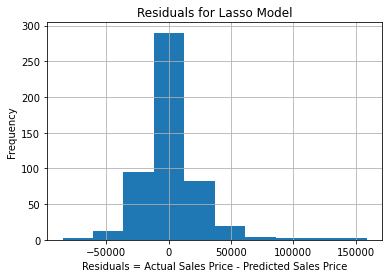

In [14]:
residuals.hist()
plt.title('Residuals for Lasso Model')
plt.xlabel('Residuals = Actual Sales Price - Predicted Sales Price')
plt.ylabel('Frequency');

The residual histogram shows that there is some right skew but it is centered around 0 which is what we want as the residual histogram should be showing the chaotic error we cannot control.

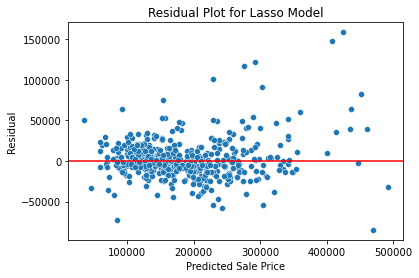

In [17]:
plt.axhline(y = 0, color='r')
sns.scatterplot(x = pred, y = residuals)
plt.title('Residual Plot for Lasso Model')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residual');

According to the residual scatter plot, there are some outliers above and the model could possibly be less biased as there is a fan pattern.  

In [15]:
RMSE = np.sqrt(metrics.mean_squared_error(y_test, pred))
RMSE

23905.574289114647

The Root Mean Squared Error is much smaller. On average, the errors are about \\$23,456 off from the actual sale prices.

## Set up Kaggle Submission

In [16]:
X = df_test[features]
Z = sc.transform(X)

In [17]:
pred = lasso_cv.predict(Z)

In [18]:
df_test['saleprice'] = pred

In [19]:
df_test.head()
lasso_submission = df_test[['id', 'saleprice']]
lasso_submission.head()

,id,saleprice
0,2658,131425.141606
1,2718,161851.994360
2,2414,209623.408539
3,1989,113792.520953
4,625,190206.132266


In [20]:
lasso_submission.set_index('id', inplace=True) 

In [21]:
lasso_submission.to_csv('../../datasets/Model_submissions/lasso_submission.csv') 


## Identify the Features that Contributed to the Lasso Model

In [22]:
lasso_coefs = lasso_cv.coef_

These coefficients are not interpretable as they are but I can do the inverse transform of the values to make them into dollar values. ([*source*: Tan from Office hours])

In [ ]:
unscaled_coef = sc.inverse_transform(lasso_cv.coef_)
unscaled_coef

In [19]:
unscaled_coefs = pd.Series(unscaled_coef, X.columns)
unscaled_coefs

1st_flr_sf                            -6.509004e+06
2nd_flr_sf                            -7.569335e+06
3ssn_porch                            -1.369263e+03
bedroom_abvgr                         -1.298925e+03
bsmt_cond                             -3.033304e+03
bsmt_full_bath                         2.911965e+03
bsmt_half_bath                         1.457578e+02
bsmt_qual                             -1.362124e+03
bsmt_unf_sf                           -2.948398e+06
bsmtfin_sf_1                           1.264427e+06
bsmtfin_sf_2                          -1.779646e+05
condition_1                           -4.078079e+03
condition_2                           -2.247061e+02
enclosed_porch                         5.620966e+04
exter_cond                             3.924912e+02
exter_qual                             5.086930e+03
fireplace_qu                           3.951425e+03
fireplaces                            -3.043551e+03
full_bath                              3.010169e+03
functional  

Below are the top 10 most influential features according to their absolute value of their coefficients.

In [48]:
unscaled_coefs.sort_values(ascending = False)[:8]

1st_flr_and_total_bsmt_sqft    1.290830e+10
overall_qual_gr_liv_area       3.227886e+08
yr_remod_or_built              2.686934e+08
lot_area                       3.618957e+07
garage_space                   9.835832e+06
total_bsmt_sf                  2.431934e+06
bsmtfin_sf_1                   1.264427e+06
garage_yr_blt                  4.892457e+05
dtype: float64

In [45]:
unscaled_coefs.sort_values(ascending = False)[-5:] 

bsmt_unf_sf                           -2.948398e+06
1st_flr_sf                            -6.509004e+06
2nd_flr_sf                            -7.569335e+06
sqft_above                            -2.122760e+09
1st_flr_gr_liv_area_total_bsmt_sqft   -9.634220e+11
dtype: float64

This model performed the best. After changing the scalers back using the inverse_transform function I can now interpret these values for an audience. However, due to time constrants, I will be presenting the OLS model.  Due to the OLS model having less features to describe and a more direct analysis for an audience, it will be used in the presenation. If more time were available, I would rework the presentation to include the LASSO model instead. 